## MLZoomcamp Week 4 - Evaluation

In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [76]:
df = pd.read_csv('data.csv')

In [77]:
df.columns

Index(['Make', 'Model', 'Year', 'Engine Fuel Type', 'Engine HP',
       'Engine Cylinders', 'Transmission Type', 'Driven_Wheels',
       'Number of Doors', 'Market Category', 'Vehicle Size', 'Vehicle Style',
       'highway MPG', 'city mpg', 'Popularity', 'MSRP'],
      dtype='object')

In [78]:
df = df[['Make', 'Model', 'Year', 'Engine HP',
       'Engine Cylinders', 'Transmission Type', 'Vehicle Style',
       'highway MPG', 'city mpg', 'MSRP']]

#### Data preparation

    Keep only the columns above
    Lowercase the column names and replace spaces with underscores
    Fill the missing values with 0
    Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable above_average

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [79]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [80]:
df = df.fillna(0)

In [81]:
df = df.rename(columns ={'msrp':'price'})

In [82]:
df.price.mean()

40594.737032063116

In [83]:
def above_average(value):
    if value > df.price.mean():
        return 1
    else: return 0   

In [84]:
df['above_average'] = df['price'].map(above_average)


In [85]:
df.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg',
       'price', 'above_average'],
      dtype='object')

In [86]:
del df['price']

In [87]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [88]:
len(df_full_train), len(df_test), len(df_train), len(df_val)

(9531, 2383, 7148, 2383)

#### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

    For each numerical variable, use it as score and compute AUC with the above_average variable
    Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

    engine_hp
    engine_cylinders
    highway_mpg
    city_mpg


In [89]:
from sklearn.metrics import roc_auc_score

In [90]:
roc_auc_score(df_train.above_average, df_train.engine_hp)

0.9171031265539011

In [91]:
#col = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
col = ['year', 'engine_hp', 'engine_cylinders',  'highway_mpg', 'city_mpg']
for c in col:
    print(c + '   ' + str(roc_auc_score(df_train.above_average, df_train[c])))

year   0.687551492804683
engine_hp   0.9171031265539011
engine_cylinders   0.766116490165669
highway_mpg   0.3669412128227987
city_mpg   0.3265755356754767


#### Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

    0.678
    0.779
    0.878
    0.979


In [92]:
y_full_train = df_full_train['above_average']
y_test = df_test['above_average']
y_train = df_train['above_average']
y_val = df_val['above_average']

In [93]:
X_full_train = df_full_train[['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg']]
X_test = df_test[['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg']]
X_train = df_train[['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg']]
X_val = df_val[['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg']]

In [94]:
len(df_train), len(df_val), len(df_test), len(df_full_train)

(7148, 2383, 2383, 9531)

In [95]:
len(y_train), len(y_val), len(y_test), len(y_full_train)

(7148, 2383, 2383, 9531)

In [96]:
dv = DictVectorizer(sparse=False)
train_dict = X_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
val_dict = X_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [97]:
len(df_val[df_val['above_average']==1])

654

In [98]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train,y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [99]:
y_pred = model.predict_proba(X_val)[:, 1]


In [100]:
roc_auc_score(y_val,y_pred)

0.9790336815928319

In [101]:
a_a = (y_pred >= 0.5).astype(int)
a_a

array([1, 0, 0, ..., 0, 1, 0])

In [102]:
(y_val == a_a).mean()

0.9341166596726815

In [103]:
df_pred = pd.DataFrame()
df_pred['actual'] = y_val
df_pred['probability'] = y_pred
df_pred['prediction'] = a_a.astype(int)
df_pred['correct'] = df_pred.prediction == df_pred.actual

In [104]:
df_pred.correct.mean().round(2)

0.93

#### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

    Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
    For each threshold, compute precision and recall
    Plot them

At which threshold precision and recall curves intersect?

    0.28
    0.48
    0.68
    0.88


In [105]:
thresholds = np.arange(0, 1.0, 0.01)
prec = []
rec = []
for t in thresholds:

    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)

    prec.append(p)
    rec.append(r)


In [106]:
thresholds = np.arange(0, 1.0, 0.01)
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

In [107]:
columns = [ 'thresholds','prec', 'rec']
scores = [thresholds, prec, rec]
#df['column_name']=pd.Series(arr)
df_scores = pd.DataFrame(scores, columns)
df_scores = df_scores.T
df_scores

,thresholds,prec,rec
0,0.00,0.274444,1.000000
1,0.01,0.461103,0.996942
2,0.02,0.507009,0.995413
3,0.03,0.540249,0.995413
4,0.04,0.570175,0.993884
...,...,...,...
95,0.95,0.993377,0.458716
96,0.96,0.996454,0.429664
97,0.97,0.996241,0.405199
98,0.98,1.000000,0.363914


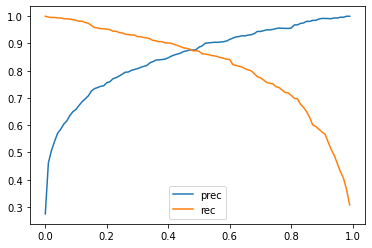

In [108]:
plt.plot(df_scores.thresholds, df_scores['prec'], label='prec')
plt.plot(df_scores.thresholds, df_scores['rec'], label='rec')
plt.legend()

#### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

Where is precision and

is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

    0.12
    0.32
    0.52
    0.72


In [131]:
def f1_score(p,r):
    a = p*r
    b = p+r
    c = a/b
    f1 = 2*c
    return f1
    

In [132]:
df_scores['f1_score'] = df_scores.apply(lambda x: f1_score(x['prec'],x['rec']), axis = 1)


In [133]:
df_scores[df_scores['f1_score'] == df_scores['f1_score'].max()]

,thresholds,prec,rec,f1_score
52,0.52,0.9008,0.860856,0.880375


#### Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

In [ ]:
KFold(n_splits=5, shuffle=True, random_state=1)

#### Iterate over different folds of df_full_train
    Split the data into train and validation
    Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

    0.003
    0.030
    0.090
    0.140
